## Importing Useful Libraries and Dataset

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

In [13]:
''' 
"stocks" dataframe contains daily historic YTD returns of 10 random stocks

Todo: Use a bigger set (ex: 50 stocks)
'''

stocks = pd.read_excel("Data/grid1_pzafurjz.xlsx")
stocks.rename(columns= {'Unnamed: 0': "Date"},inplace = True)
stocks = stocks[stocks["Date"].isna() == False]

### Data Preprocessing

In [14]:
#reverse order of dates
stocks = stocks[::-1]
stocks = stocks.reset_index()
stocks.drop("index", axis = 1, inplace = True)

In [15]:
#removing US holidays
stocks = stocks[stocks["META US Equit"] != " "]

In [16]:
#for Non US stocks, for Nan values copy the previous value
stocks.loc[stocks["RACE IM Equit"] == " ",
          ["IBE SM Equity","RACE IM Equit"]] = np.array(stocks.iloc[[66,81]][["IBE SM Equity","RACE IM Equit"]])

In [17]:
stocks = stocks.reset_index().drop("index", axis = 1)
stocks = stocks.set_index("Date")
stocks.head(5)

,META US Equit,AAPL US Equit,MSFT US Equit,CAT US Equity,BAC US Equity,IBE SM Equity,RACE IM Equit,NVDA US Equi,QQQ US Equity,ORGN US Equi
Date,,,,,,,,,,
2022-12-30,120.34,129.93,239.82,239.56,33.12,11.70712,214.43422,146.14,266.28,4.61
2023-01-03,124.74,125.07,239.58,238.88,33.51,11.57423,214.92747,143.15,264.48,4.63
2023-01-04,127.37,126.36,229.1,241.36,34.14,11.78438,218.61028,147.49,265.74,4.92
2023-01-05,126.94,125.02,222.31,240.28,34.07,11.64091,216.8127,142.65,261.58,4.85
2023-01-06,130.02,129.62,224.93,248.86,34.41,11.60074,222.22781,148.59,268.8,5.02


In [18]:
#create return 
#could use this instead pd.pct_change
returns = stocks.astype(float)[1:].reset_index().sub(stocks.astype(float)[:-1].reset_index(), axis =1)
returns.drop("Date",inplace = True,axis =1)

In [19]:
returns = returns.div(stocks.astype(float)[:-1].reset_index().drop("Date",axis = 1)) *100

## IMPORTING S&P100 RETURNS

In [20]:
#initialize indexes
sp100_companies = [
    'AAPL', 'ABBV', 'ABT', 'ACN', 'ADBE', 'AIG', 'ALL', 'AMGN', 'AMT', 'AMZN',
    'AXP', 'BA', 'BAC', 'BIIB', 'BK', 'BKNG', 'BLK', 'BMY', 'BRK-B', 'C', 'CAT',
    'CHTR', 'CL', 'CMCSA', 'COF', 'COP', 'COST', 'CRM', 'CSCO', 'CVS', 'CVX',
    'DD', 'DHR', 'DIS', 'DOW', 'DUK', 'EMR', 'EXC', 'F',  'FDX', 'GD',
    'GE', 'GILD', 'GM', 'GOOGL', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM',
    'KHC', 'KO', 'LIN', 'LLY', 'LMT', 'LOW', 'MA', 'MCD', 'MDLZ', 'MDT', 'MET', 'META',
    'MMM', 'MO', 'MRK', 'MS', 'MSFT', 'NEE', 'NFLX', 'NKE', 'NVDA', 'ORCL', 'PEP',
    'PFE', 'PG', 'PM', 'PYPL', 'QCOM', 'RTX', 'SBUX', 'SO', 'SPG', 'T', 'TGT',
    'TMO', 'TMUS', 'TSLA', 'TXN', 'UNH', 'UNP', 'UPS', 'USB', 'V', 'VZ', 'WBA',
    'WFC', 'WMT', 'XOM'
]

In [21]:
import yfinance as yf
# Define the start and end dates
start_date = '2021-01-01'
end_date = '2023-06-07'

# Create an empty DataFrame to store the data
sp100_data = pd.DataFrame()

# Retrieve data for each ticker symbol
for symbol in sp100_companies:
    try:
        # Download historical data using yfinance
        data = yf.download(symbol, start=start_date, end=end_date)
        
        # Extract the 'Open' column and add it to sp100_data DataFrame
        sp100_data[symbol] = data['Open']
    except Exception as e:
        print(f"Error retrieving data for {symbol}: {e}")



In [22]:
sp100returns = sp100_data.pct_change()

### Initialize the setting

In [43]:
from EWPortfolio0 import EquallyWeightedPortfolio
from ONPortfolio import OnlinePortfolioSelection
from Opt import HedgeAlgorithm, OnlineGradientDescent
from VWPortfolio0 import ValueWeightedPortfolio

In [44]:
EW = EquallyWeightedPortfolio(stock = stocks, returns = returns,eta = 0.005)
Portfolio = OnlinePortfolioSelection(stock = stocks, returns = returns,eta = 0.005)
VW = ValueWeightedPortfolio(stock = stocks, returns = returns,eta = 0.005)

In [45]:
EW.run()
Portfolio.run()
VW.run()

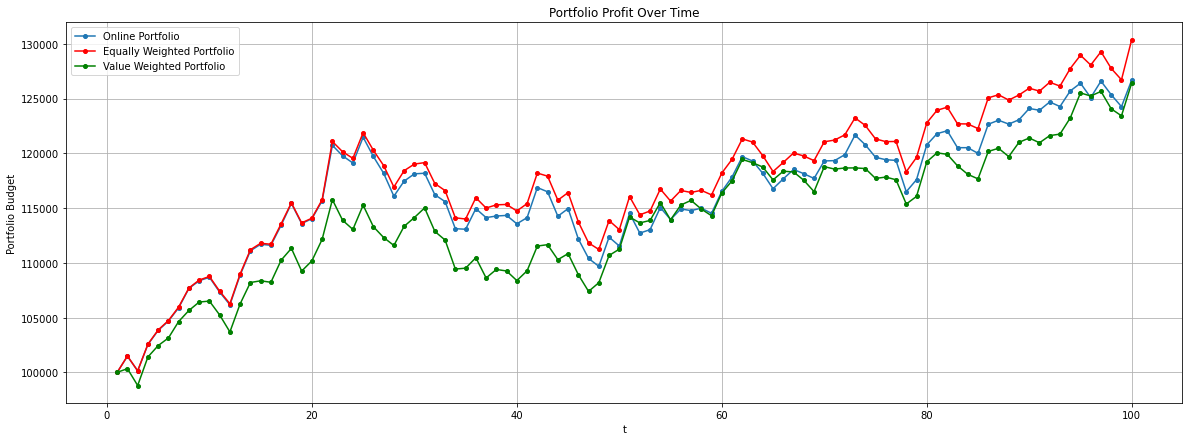

<Figure size 936x504 with 0 Axes>

In [46]:
Portfolio.benchmark(benchmark = [EW,VW])

In [48]:
EWSP100 = EquallyWeightedPortfolio(sp100_data,returns = sp100returns,eta =0.1)
PortfolioSP100 = OnlinePortfolioSelection(stock = sp100_data, returns = sp100returns,eta =0.1)
VWSP100 = ValueWeightedPortfolio(sp100_data,returns = sp100returns,eta =0.1)

In [344]:
avg_returns = []
avg_budget = 100000
for t in range (1,len(sp100_data)-1):
    avg_budget += avg_budget * sp100returns.iloc[t].mean()
    avg_returns.append(avg_budget)

In [49]:
EWSP100.run()
PortfolioSP100.run()
VWSP100.run()

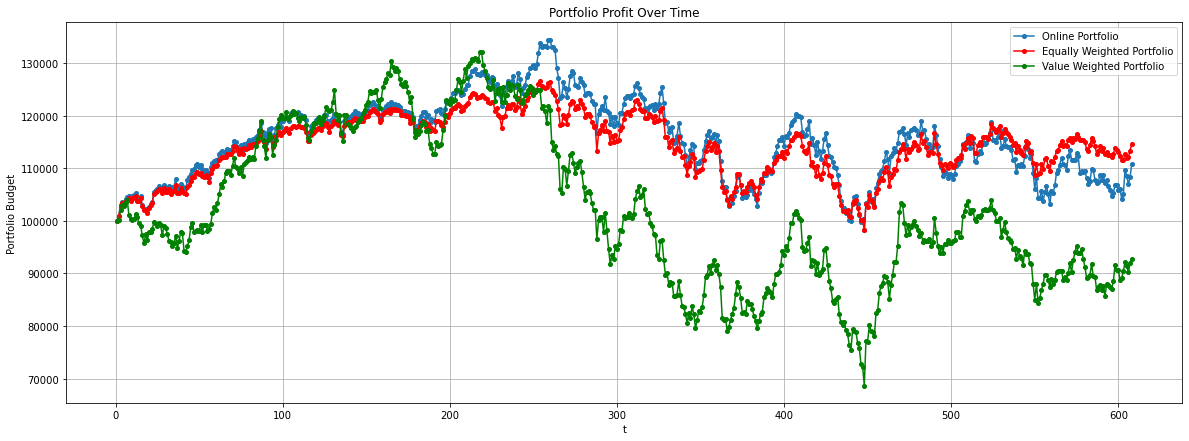

<Figure size 936x504 with 0 Axes>

In [50]:
PortfolioSP100.benchmark(benchmark = [EWSP100,VWSP100])